In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Project directory

#project_dir = "C:/Users/Alex/Documents/University/FourthYear/CSC420/Project/"
project_dir = "/content/drive/My Drive/CSC420_Project/"

In [3]:
# install OpenCV
!pip install opencv-python

# pytorch
!pip install torch
!pip3 install torchvision

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [0]:
# SECTION 1
# Word detection

In [0]:
# Load EAST word detector
# https://www.learnopencv.com/deep-learning-based-text-detection-using-opencv-c-python/
# https://github.com/spmallick/learnopencv/blob/master/TextDetectionEAST/textDetection.py
net = cv2.dnn.readNet(project_dir+"Models/frozen_east_text_detection.pb")

In [0]:
# Imports from reference
import math

def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if(score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

In [0]:
# Output layers
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")

# Prepare input
def load_img(name, t="png"):
  img = cv2.imread(project_dir+"Data/Misc_Images/{}.{}".format(name,t))
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img3 = load_img('misc3')
img4 = load_img('misc4')
img5 = load_img('misc5','jpg')

test_img = img4

In [0]:
# params
confThreshold = 0.5
nmsThreshold = 0.3
inpWidth = 320
inpHeight = 320

def segment_text(img_):
  img = img_.copy()

  blob = cv2.dnn.blobFromImage(img, 1.0, (inpWidth,inpHeight), (123.68, 116.78, 103.94), False, False)
  rW = img.shape[1] / float(inpWidth)
  rH = img.shape[0] / float(inpHeight)

  net.setInput(blob)
  output = net.forward(outputLayers)
  
  scores = output[0]
  geometry = output[1]

  [boxes, confidences] = decode(scores, geometry, confThreshold)
  indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)

  # Get image
  for i in indices:
      # get 4 corners of the rotated rect
      vertices = cv2.boxPoints(boxes[i[0]])
      # scale the bounding box coordinates based on the respective ratios
      for j in range(4):
          vertices[j][0] *= rW
          vertices[j][1] *= rH
      for j in range(4):
          p1 = (vertices[j][0], vertices[j][1])
          p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
          cv2.line(img, p1, p2, (0, 255, 0), 2, cv2.LINE_AA)

  return img,boxes

In [0]:
# Get list of images of words and their original coordinates
def get_text_img_list(img):
  img_out = img.copy()
  blob = cv2.dnn.blobFromImage(img, 1.0, (inpWidth,inpHeight), (123.68, 116.78, 103.94), False, False)
  rW = img.shape[1] / float(inpWidth)
  rH = img.shape[0] / float(inpHeight)

  net.setInput(blob)
  output = net.forward(outputLayers)
  
  scores = output[0]
  geometry = output[1]

  [boxes, confidences] = decode(scores, geometry, confThreshold)
  indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)
  sub_images = []
  word_coords = []
  for i in indices:
      # get 4 corners of the rotated rect
      vertices = cv2.boxPoints(boxes[i[0]])
      for j in range(4):
          vertices[j][0] *= rW
          vertices[j][1] *= rH

      x1 = max(int(vertices[0][0]) - 2, 0)
      y1 = min(int(vertices[0][1]) + 12, img.shape[0])
      x2 = min(int(vertices[2][0]) + 2, img.shape[1])
      y2 = max(int(vertices[2][1]) - 5, 0)
  
      sub_images.append(img[y2:y1,x1:x2])
      word_coords.append([x1,y1,x2,y2])
      cv2.rectangle(img_out, (x1,y1), (x2,y2), (0,250,0),1)

  return sub_images, word_coords, img_out
  
found_words, word_coords, new_img = get_text_img_list(test_img)

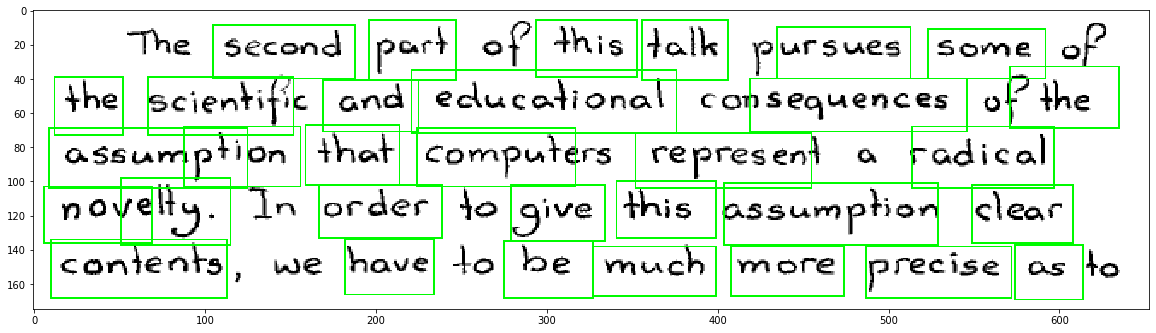

In [42]:
plt.figure(figsize=(20,20))
plt.imshow(new_img)

In [0]:
# SECTION 2
# Letter detection

In [0]:
# Threshold the letters in whole image before looking at individual words
# Can then check for each word if we have missed any words altogether
# We do this because the word detector does not always see all the words
def get_all_chars(input_image):
  all_char = []

  im = cv2.cvtColor(input_image.copy(), cv2.COLOR_RGB2GRAY)
  # try with just thresholding and then looking for contours
  ret, thresh = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # Different versions of open cv
  #
  major = cv2.__version__.split('.')[0]
  if major == '3':
    _, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  else:
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for i, ctr in enumerate(contours):
      x, y, w, h = cv2.boundingRect(ctr)

      # needs to be big enough to count
      if h <= 5:
        continue

      if hierarchy[0, i, 3] == -1:
          all_char.append([x, y, x + w, y + h])
  return all_char

all_chars = get_all_chars(test_img)

In [0]:
from statistics import mean

# store avg width of chars
avg_char_width = 0
char_widths = []
for c in all_chars:
  char_widths.append(c[2]-c[0])
  
avg_char_width = mean(char_widths)

# detect the letters within a given word
def detect_with_thresh(input_image): # input word
  im = cv2.cvtColor(input_image.copy(),cv2.COLOR_RGB2GRAY)
  ret, thresh = cv2.threshold(im, 120, 255, cv2.THRESH_BINARY_INV)

  # Different versions of open cv
  #
  major = cv2.__version__.split('.')[0]
  if major == '3':
    _, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  else:
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # get all rectangles defined by the contours
  rectangles = []
  for i, ctr in enumerate(contours):
      x, y, w, h = cv2.boundingRect(ctr)

      # needs to be big enough
      if h <= 5:
        continue

      if hierarchy[0, i, 3] == -1:
          rectangles.append([x, y, x + w, y + h])
  
  # the following code takes rectangles that are 'too wide', assumes they
  # are actually two letters, and then splits them apart.
  r = []
  for i,rect in enumerate(rectangles):
    w = rect[2]-rect[0]
    if w < avg_char_width*1.75:
      r.append(rect)
      cv2.rectangle(im, (rect[0], rect[1]), ( rect[2],rect[3]), (0, 255, 0), 1)
    else:
      r1 = [rect[0],rect[1],rect[0]+int(w/2),rect[3]]
      r2 = [rect[0]+int(w/2),rect[1],rect[0]+w,rect[3]]
 
      # in case the bounds should change
      im1 = thresh[r1[1]:r1[3],r1[0]:r1[2]]
      im2 = thresh[r2[1]:r2[3],r2[0]:r2[2]]
      if major == '3':
        _, c1, h1 = cv2.findContours(im1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        _, c2, h2 = cv2.findContours(im2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      else:
        c1, h1 = cv2.findContours(im1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        c2, h2 = cv2.findContours(im2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      def get_max_ctr(ctrs):
        max_hw = 0
        max_ctr = None
        for ctr in ctrs:
          x, y, w, h = cv2.boundingRect(ctr)
          if w*h > max_hw:
            max_ctr = ctr
            max_hw = w*h
        return max_ctr

      c1 = get_max_ctr(c1)
      c2 = get_max_ctr(c2)
      x, y, w, h = cv2.boundingRect(c1)
      x+=r1[0]
      y+=r1[1]
      r.append([x, y, x + w, y + h])
      cv2.rectangle(im, (x, y), ( x + w, y + h), (0, 255, 0), 1)

      x, y, w, h = cv2.boundingRect(c2)
      x+=r2[0]
      y+=r2[1]
      r.append([x, y, x + w, y + h])
      cv2.rectangle(im, (x, y), ( x + w, y + h), (0, 255, 0), 1)

  return im, r



In [0]:
# the following handles the potential missing words described above
def find_missing_chars(word_coords, ctr_coords, thresh):
  for word in word_coords:
    word = [word[0], word[3], word[2], word[1]]
    i = 0
    while i < len(ctr_coords):
      curr = ctr_coords[i]
      if curr[0] > word[0] - thresh and curr [1] > word[1] - thresh and curr[2] < word[2] + thresh and curr[3] < word[3] + thresh:
        ctr_coords.pop(i)
      else:
        i += 1
  
  return ctr_coords

def group_missing_chars(ctr_coords, thresh):
  groups = []
  start = None

  while len(ctr_coords) > 0:
    if start == None:
      start = ctr_coords[0]
      ctr_coords.pop(0)
      min_x = start[0]
      max_x = start[2]
      min_y = start[1]
      max_y = start[3]
    
    added = 0
    i = 0
    while i < len(ctr_coords):
      curr = ctr_coords[i]
      # check if same line
      if abs(curr[1] - min_y) < thresh or abs(curr[3] - max_y) < thresh:
        # check if to the left of our built word so far
        if abs(curr[2] - min_x) < thresh:
          added += 1
          min_x = min(min_x, curr[0])
          min_y = min(min_y, curr[1])
          max_y = max(max_y, curr[3])
          ctr_coords.pop(i)
        elif abs(curr[0] - max_x) < thresh:
          added += 1
          max_x = max(max_x, curr[2])
          min_y = min(min_y, curr[1])
          max_y = max(max_y, curr[3])
          ctr_coords.pop(i)
        else:
          i += 1
      else:
        i += 1
    
    if added == 0 or len(ctr_coords) == 0:
      groups.append([min_x, min_y, max_x, max_y])
      start = None
  return groups

def find_words(img, coords):
  words = []
  for c in coords:
    words.append(img[c[1]:c[3], c[0]:c[2]])
  return words

missing_ctrs = find_missing_chars(word_coords, all_chars[:], 10)
missing_word_coords = group_missing_chars(missing_ctrs, 10)
missing_words = find_words(test_img, missing_word_coords)

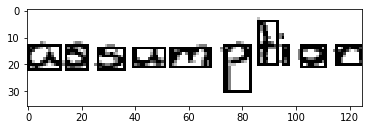

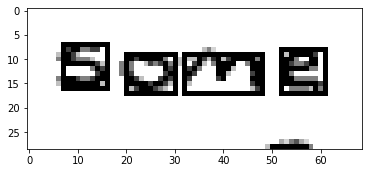

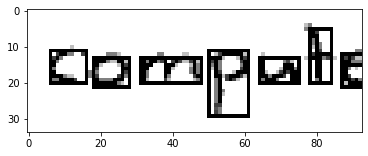

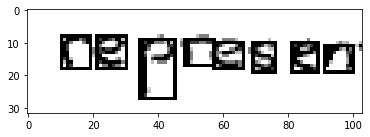

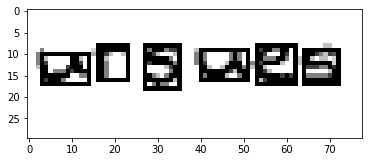

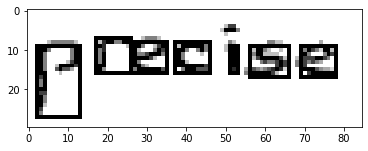

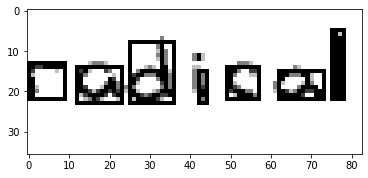

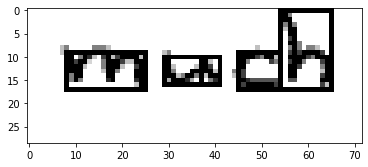

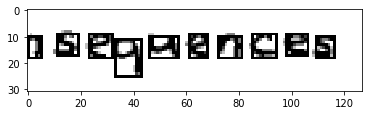

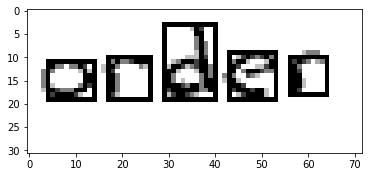

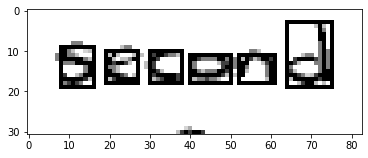

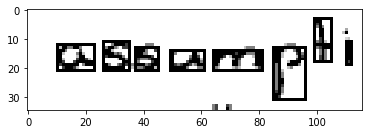

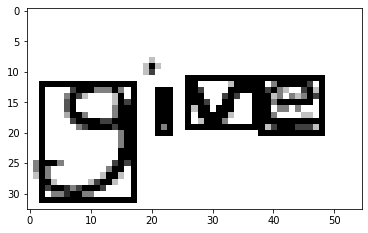

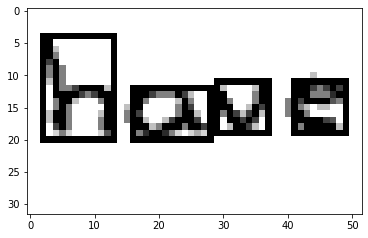

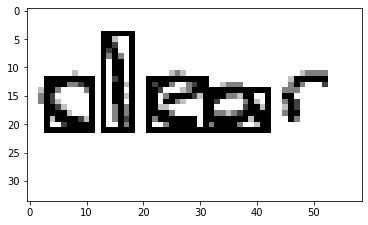

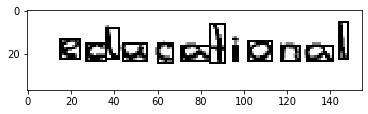

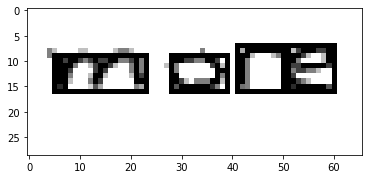

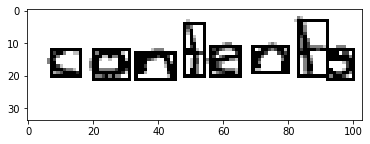

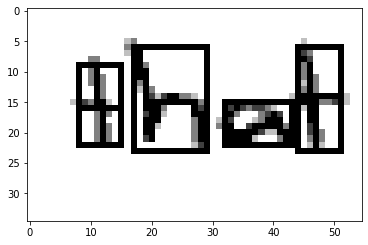

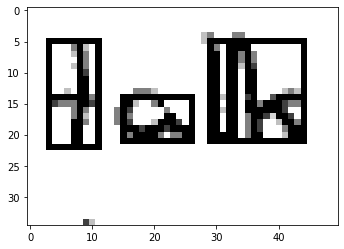

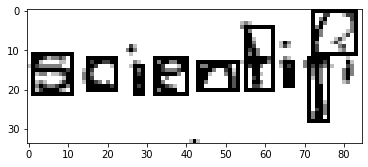

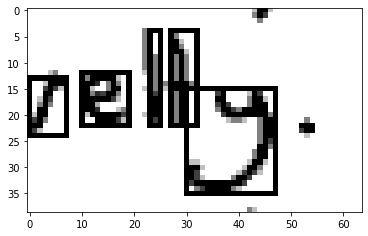

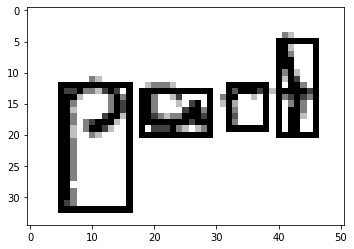

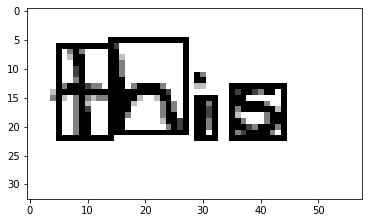

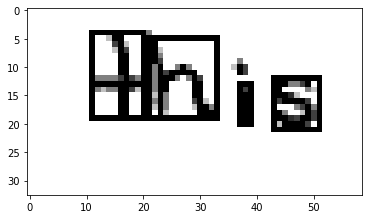

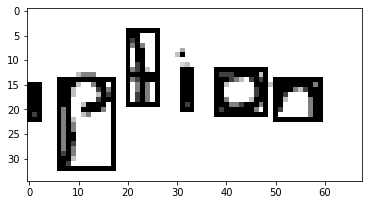

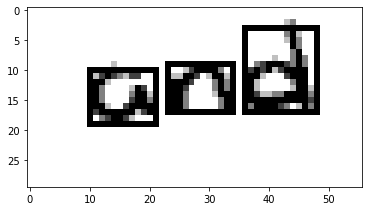

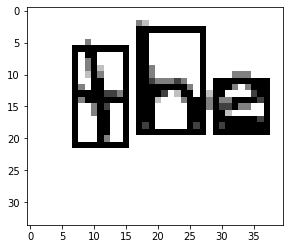

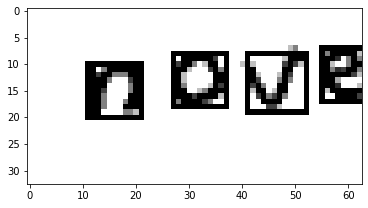

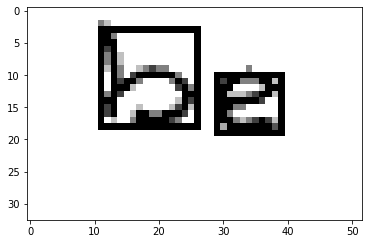

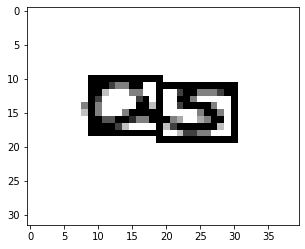

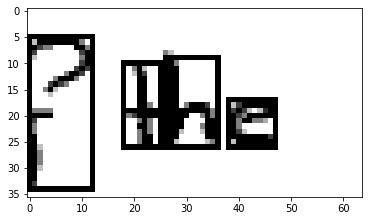

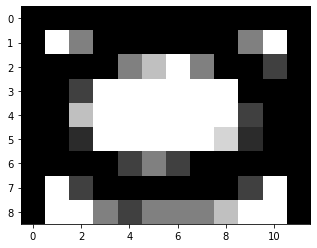

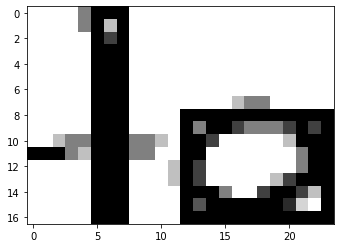

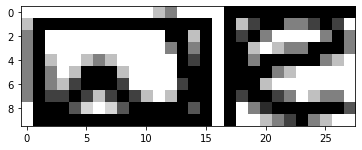

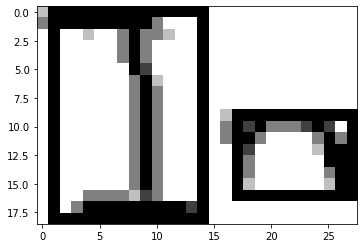

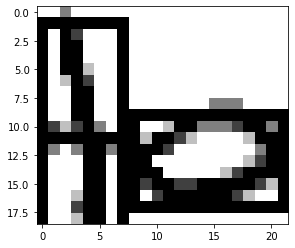

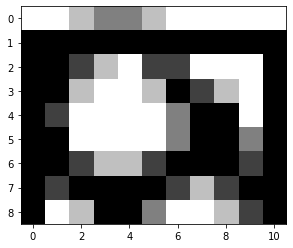

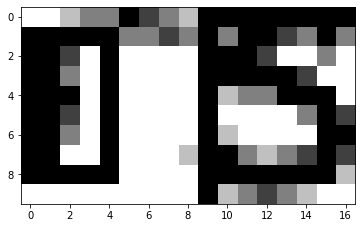

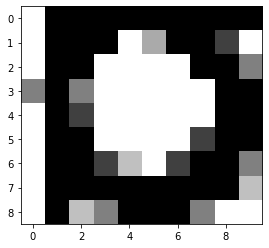

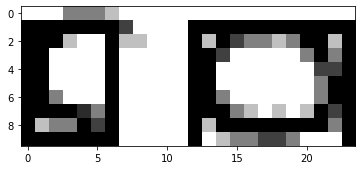

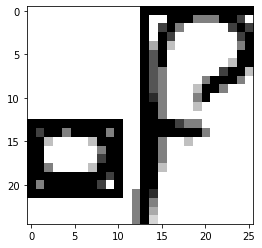

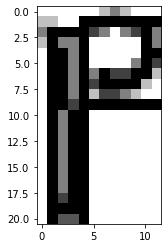

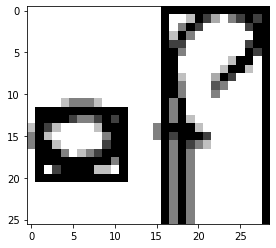

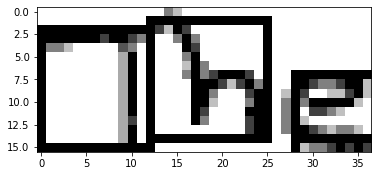

In [47]:
# add the missing words to the found words
words = found_words + missing_words
word_coords.extend(missing_word_coords)
for i,word in enumerate(words):
  im,_= detect_with_thresh(word)
  plt.figure()
  plt.imshow(im,cmap='gray')
  plt.show()


In [0]:
# SECTION 3
# Recognizing letters using ML
import torch

In [0]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# LOAD THE DATA

# custom transform that dilates and thresholds the input
class dilate(object):
  def __call__(self, sample):
    dilated = cv2.dilate(np.float32(sample),kernel=np.ones((2,2)))
    ret,dilated = cv2.threshold(dilated,0.4,1,cv2.THRESH_BINARY)
    return dilated

transform = transforms.Compose([transforms.Grayscale(),
                                dilate(),
                                transforms.ToTensor()
                               ])

dataset = datasets.ImageFolder(
      root=project_dir+'Data/alphabet_most/',
      transform= transform,
  )

# Randomly split test and train data
# https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
batch_size = 100
validation_split = .2
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

loader= torch.utils.data.DataLoader(
  dataset,
  batch_size=batch_size
)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

char_train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
char_validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [0]:
# Targets
from itertools import chain
char_valid_targets = set(chain([65,66,69,71,72,78,82], range(97,123))) # lower case + select upper case

# the target folders are numbered by their ascii value,
# but pytorch reads them in 
targets = [chr(c) for c in char_valid_targets]
combo = list(zip(char_valid_targets, targets))
combo.sort(key = lambda x: str(x[0])) # sort alphabetically
map_targets_to_chars = list(dict(combo).values()) # map chars to target value

In [0]:
# Define network for character recognition
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
      
def create_sequential(in_,out):
    return nn.Sequential(
            nn.Conv2d(in_, out, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(out, out, kernel_size=3,padding=1),
            nn.ReLU())
  
class CNN_recognizer(nn.Module):
  def __init__(self, num_outputs):
        super(CNN_recognizer, self).__init__()
        self.layer1 = create_sequential(1,32)
        self.maxPool1 = nn.MaxPool2d(2)
        self.layer2 = create_sequential(32,64)
        self.maxPool2 = nn.MaxPool2d(2)
        self.layer3 = create_sequential(64,128)
        self.maxPool3 = nn.MaxPool2d(2)
        self.layer4 = create_sequential(128,256)
        self.maxPool4 = nn.MaxPool2d(2)
        self.layer5 = create_sequential(256,128)
        self.maxPool5 = nn.MaxPool2d(4)

        self.lin1 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.lin2 = nn.Linear(128, num_outputs)
       
        
  def forward(self, x):      
        out1 = self.layer1(x)
        out = self.maxPool1(out1)
        
        out2 = self.layer2(out)
        out = self.maxPool2(out2)
        
        out3 = self.layer3(out)
        out = self.maxPool3(out3)

        out4 = self.layer4(out)
        out = self.maxPool4(out4)

        out5 = self.layer5(out)
        out = self.maxPool5(out5)
  
        out = self.lin1(out.view(out.shape[0],128))
        out = self.lin2(out)
        
        return out

In [0]:
# Init the model and set the optimizers
char_model = CNN_recognizer(len(char_valid_targets)).cuda()

char_criterion = nn.CrossEntropyLoss()
char_optimizer = optim.Adam(char_model.parameters(), lr=0.001)

In [24]:
# Load the model
char_model.load_state_dict(torch.load(project_dir+'Models/char_recognizer.tar'))

<All keys matched successfully>

In [0]:
# train
epochs = 10
for e in range(epochs):
    print('epoch', e+1) 
    running_loss = 0
    for batch, (images, labels) in enumerate(char_train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()

        vals = char_model(images)
        loss = char_criterion(vals, labels)
        print('batch:',batch,"     ",'loss:',loss.item())
 
        char_optimizer.zero_grad()
        loss.backward()
        char_optimizer.step()
        
        running_loss += loss.item()
    print(f"Training loss: {running_loss/len(char_train_loader)}")

In [0]:
# Save the model
# torch.save(char_model.state_dict(), project_dir+'Models/char_recognizer.tar')

In [0]:
# validate
accuracy = 0
for images, labels in char_validation_loader:
    images = Variable(images).cuda()
    labels = Variable(labels).cuda()

    vals = char_model(images)

    # get the predictions: argmax etc.
    ps = torch.sigmoid(vals)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    acc = torch.mean(equals.type(torch.FloatTensor))
    print(acc)
    accuracy += acc
        
print("Test Accuracy: {:.3f}".format(accuracy/len(char_validation_loader)))

tensor(0.9300)
tensor(0.9300)
tensor(0.9200)
tensor(0.9500)
tensor(0.9400)
tensor(0.9000)
tensor(0.8900)
tensor(0.9600)
tensor(0.9300)
tensor(0.9200)
tensor(0.9200)
tensor(0.9400)
tensor(0.9600)
tensor(0.9500)
tensor(0.9500)
tensor(0.9600)
tensor(0.9500)
tensor(0.9400)
tensor(0.9500)
tensor(0.9400)
tensor(0.9200)
tensor(0.9400)
tensor(0.9300)
tensor(0.8500)
tensor(0.9200)
tensor(0.9600)
tensor(0.9300)
tensor(0.9400)
tensor(0.8600)
tensor(0.9600)
tensor(0.9300)
tensor(0.9300)
tensor(0.8800)
tensor(0.9400)
tensor(0.9600)
tensor(0.9400)
tensor(0.9400)
tensor(0.9500)
tensor(0.9100)
tensor(0.9200)
tensor(0.9100)
tensor(0.8800)
tensor(0.9200)
tensor(0.9400)
tensor(0.9100)
tensor(0.9100)
tensor(0.9400)
tensor(0.9400)
tensor(0.9400)
tensor(0.9100)
tensor(0.9500)
tensor(0.9200)
tensor(0.9300)
tensor(0.9400)
tensor(0.9400)
tensor(0.9400)
tensor(0.9400)
tensor(0.9300)
tensor(0.9700)
tensor(0.9000)
tensor(0.8800)
tensor(0.8700)
tensor(0.9400)
tensor(0.8900)
tensor(0.9000)
tensor(0.9000)
tensor(0.9

In [0]:
# SECTION 4
# Input the detected letters into the neural net and determine what was written

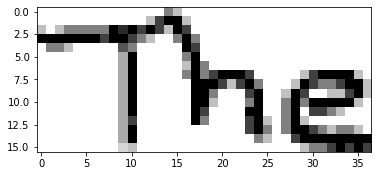

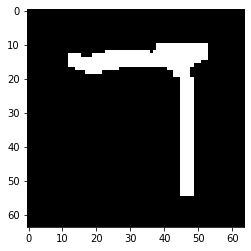

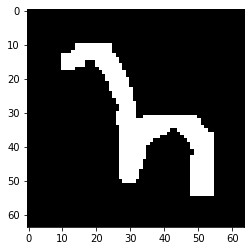

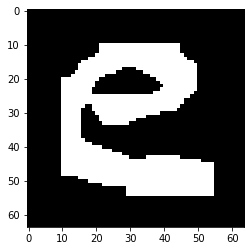

y with p-value 0.9993521571159363
h with p-value 0.9974462985992432
e with p-value 1.0
yhe


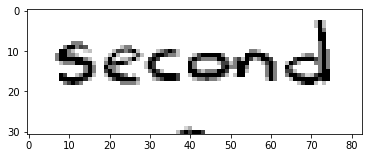

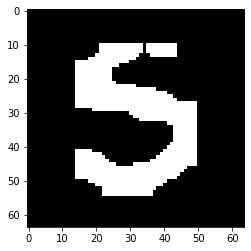

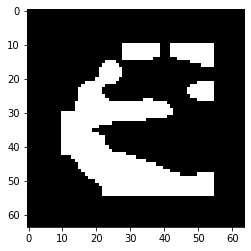

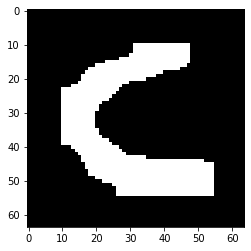

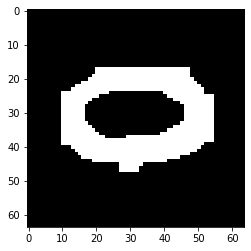

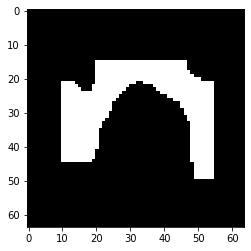

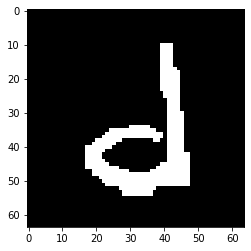

s with p-value 1.0
E with p-value 1.0
c with p-value 0.9999680519104004
a with p-value 0.9999680519104004
n with p-value 1.0
d with p-value 1.0
sEcand


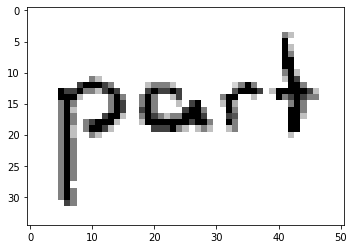

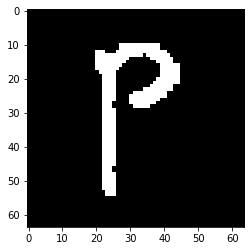

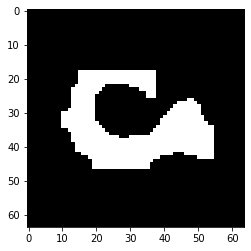

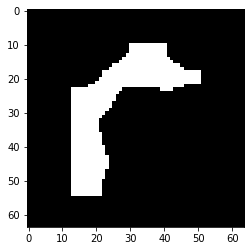

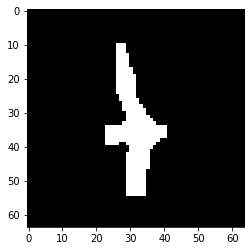

p with p-value 1.0
a with p-value 0.9999815225601196
r with p-value 1.0
t with p-value 0.9999802112579346
part


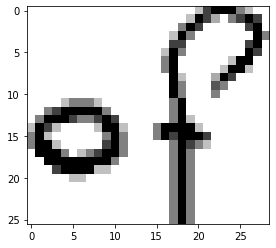

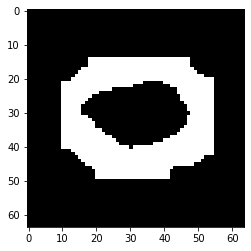

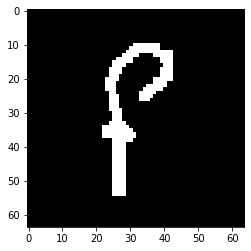

e with p-value 0.9999545812606812
p with p-value 0.9999966621398926
ep


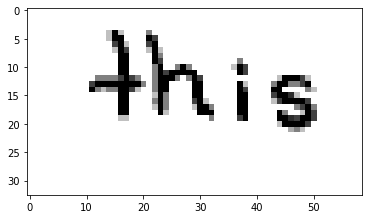

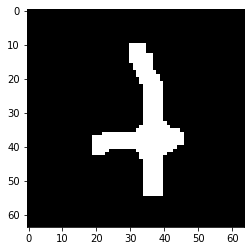

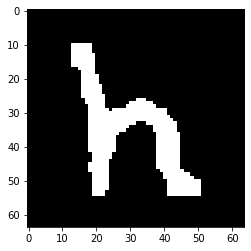

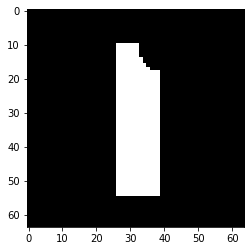

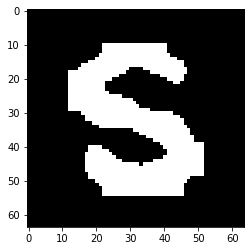

t with p-value 1.0
h with p-value 1.0
i with p-value 0.9998725652694702
s with p-value 1.0
this


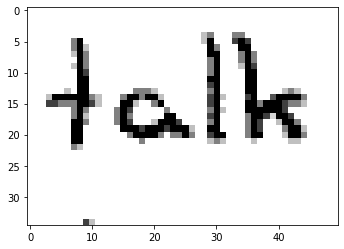

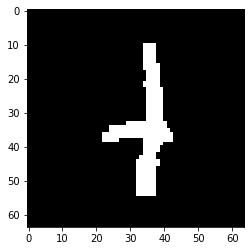

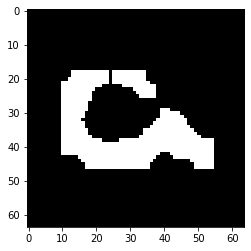

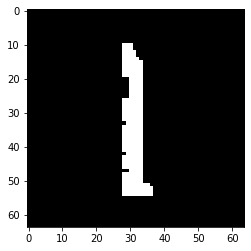

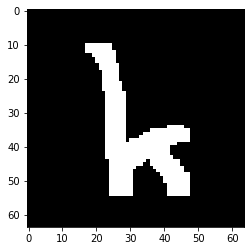

t with p-value 1.0
a with p-value 1.0
i with p-value 0.9990222454071045
h with p-value 0.9999997615814209
taih


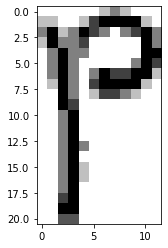

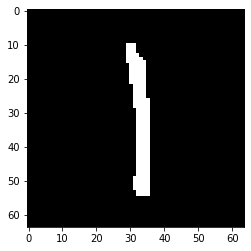

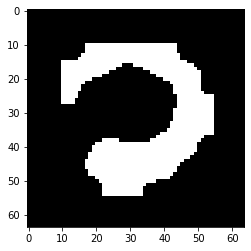

l with p-value 0.9969373941421509
o with p-value 0.9999949932098389
lo


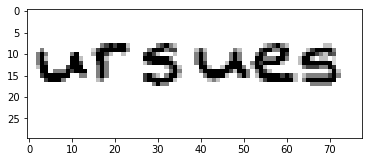

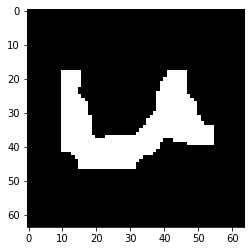

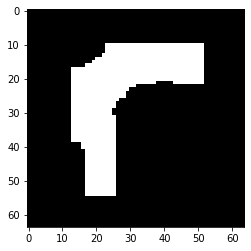

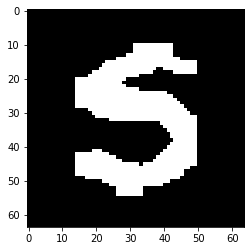

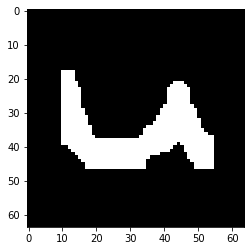

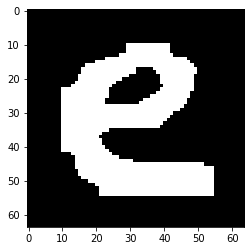

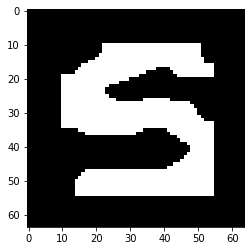

u with p-value 1.0
r with p-value 1.0
s with p-value 1.0
u with p-value 1.0
e with p-value 1.0
s with p-value 1.0
ursues


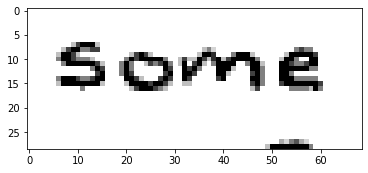

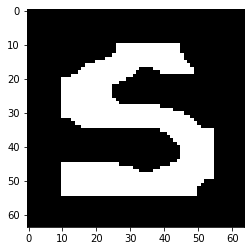

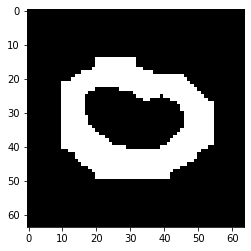

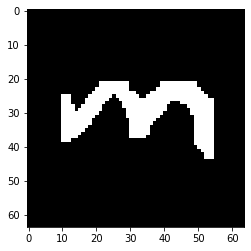

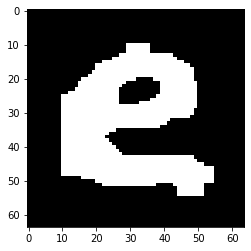

s with p-value 1.0
o with p-value 0.9999927282333374
m with p-value 1.0
e with p-value 1.0
some


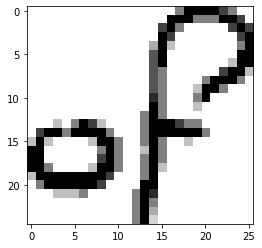

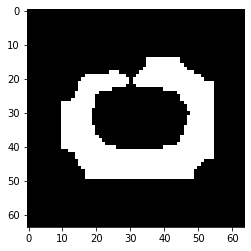

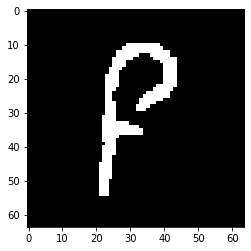

e with p-value 0.9999479055404663
p with p-value 0.9999978542327881
ep


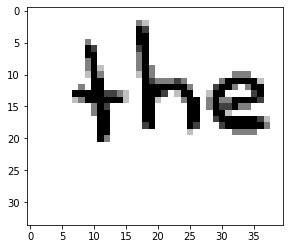

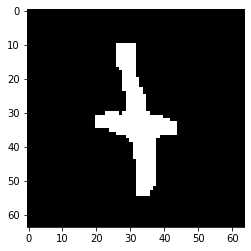

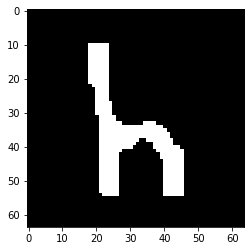

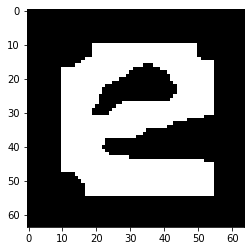

t with p-value 1.0
h with p-value 1.0
e with p-value 1.0
the


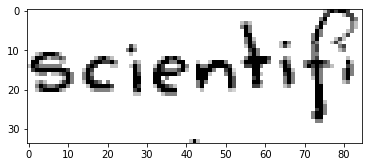

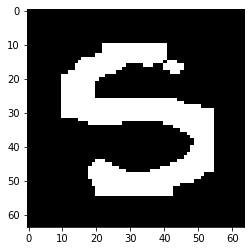

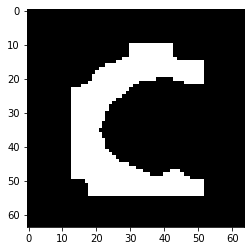

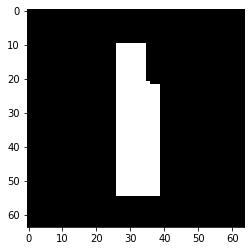

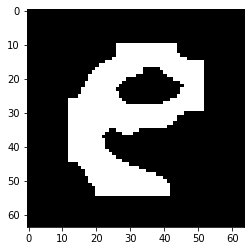

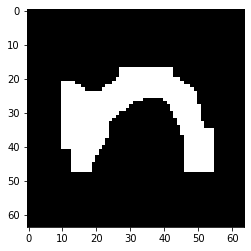

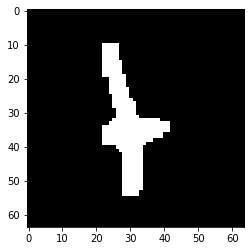

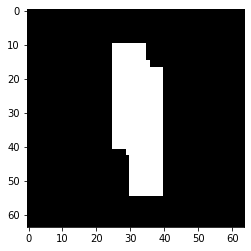

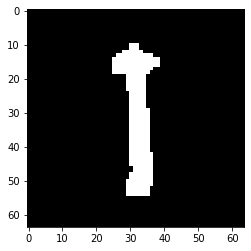

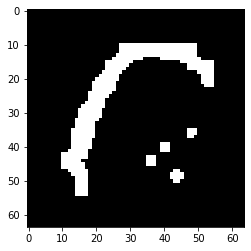

s with p-value 1.0
c with p-value 0.9999998807907104
i with p-value 0.9999226331710815
e with p-value 1.0
n with p-value 0.9999998807907104
t with p-value 0.9999504089355469
i with p-value 0.9999755620956421
l with p-value 0.9989041090011597
r with p-value 0.998296320438385
scientilr


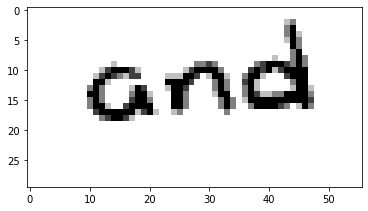

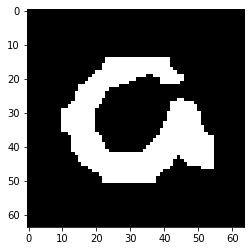

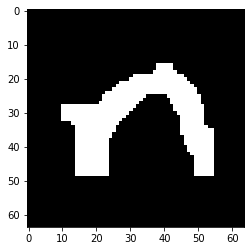

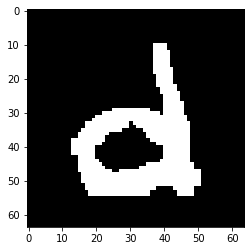

a with p-value 1.0
n with p-value 0.9999908208847046
d with p-value 1.0
and


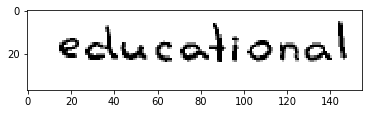

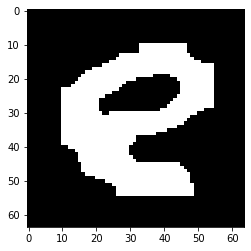

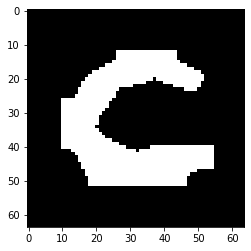

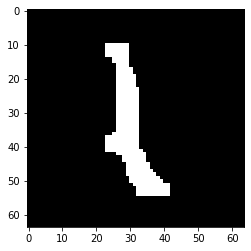

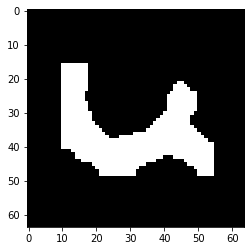

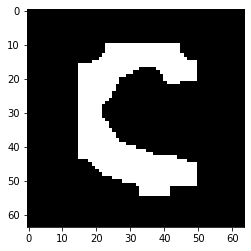

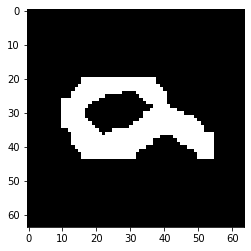

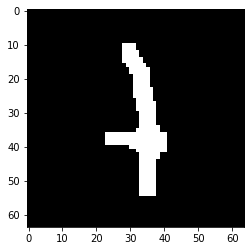

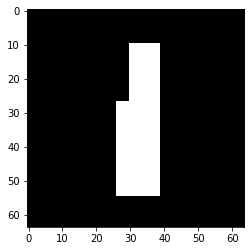

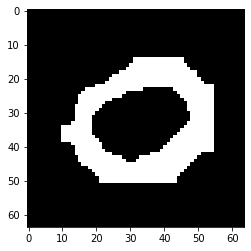

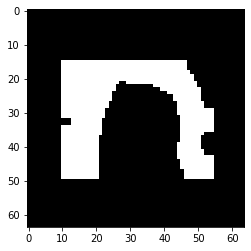

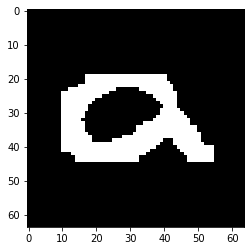

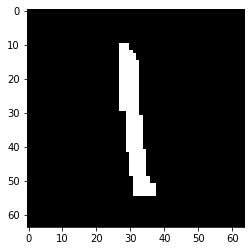

e with p-value 1.0
c with p-value 0.9999819993972778
e with p-value 0.9854898452758789
u with p-value 1.0
c with p-value 0.9994655251502991
a with p-value 1.0
t with p-value 0.9999994039535522
i with p-value 0.9999375343322754
e with p-value 0.999994158744812
n with p-value 0.9999994039535522
a with p-value 1.0
l with p-value 0.9994977712631226
eceucatienal


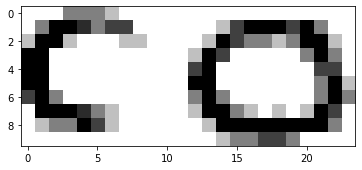

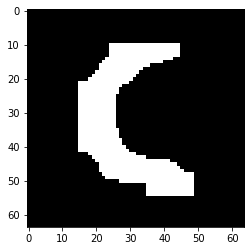

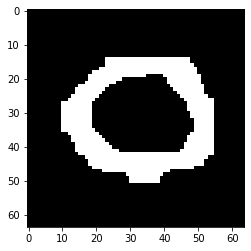

r with p-value 0.9990768432617188
e with p-value 0.9999587535858154
re


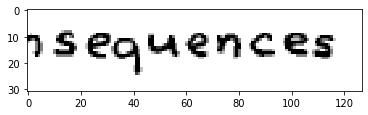

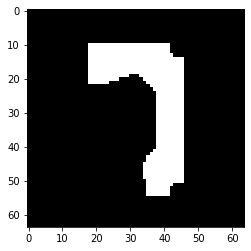

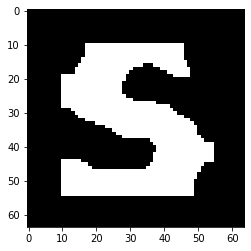

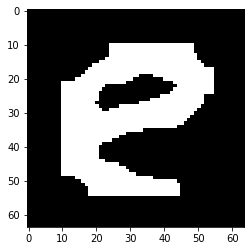

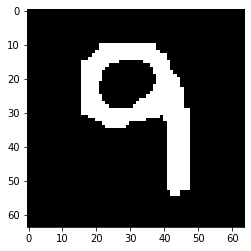

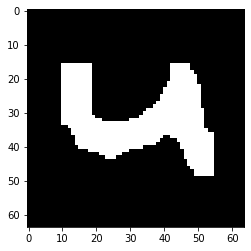

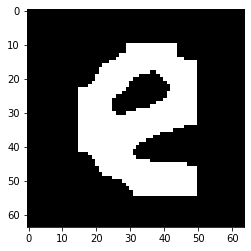

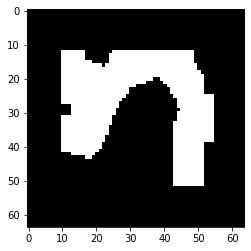

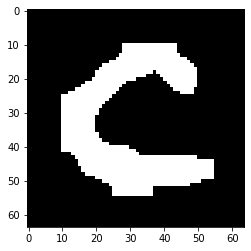

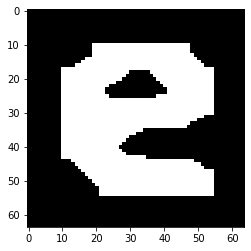

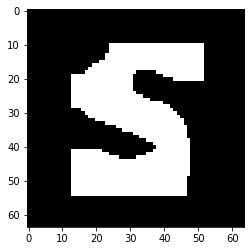

n with p-value 0.9885351061820984
s with p-value 1.0
e with p-value 1.0
q with p-value 1.0
u with p-value 0.9999997615814209
e with p-value 1.0
n with p-value 0.9999998807907104
c with p-value 0.9999998807907104
e with p-value 1.0
s with p-value 1.0
nsequences


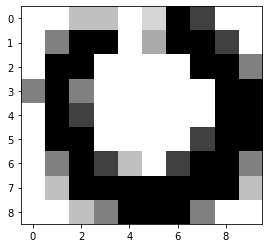

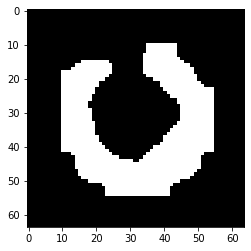

o with p-value 1.0
o


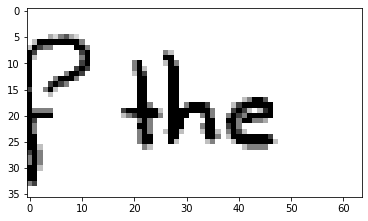

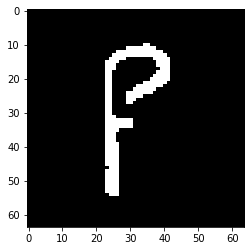

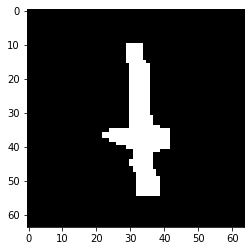

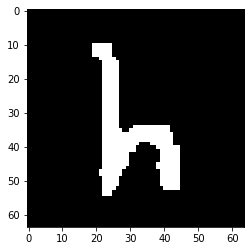

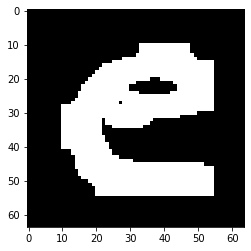

p with p-value 0.9999979734420776
t with p-value 0.9999997615814209
h with p-value 1.0
e with p-value 1.0
pthe


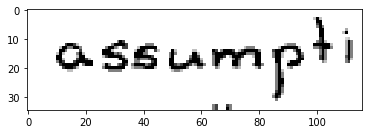

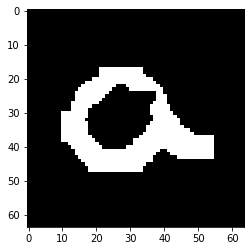

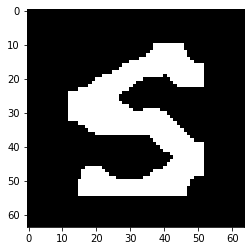

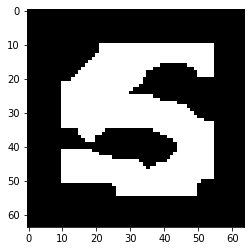

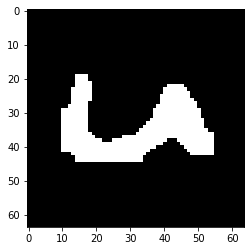

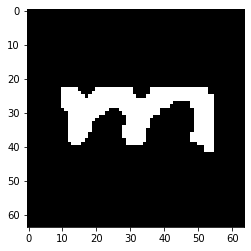

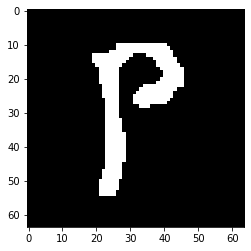

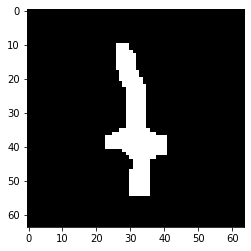

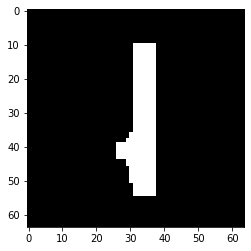

a with p-value 1.0
s with p-value 1.0
s with p-value 1.0
u with p-value 1.0
m with p-value 1.0
p with p-value 1.0
t with p-value 0.9999988079071045
i with p-value 0.9958767890930176
assumpti


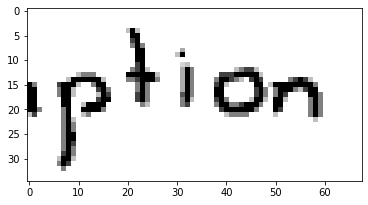

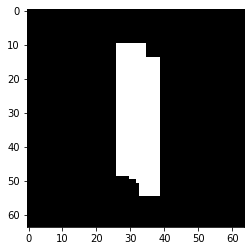

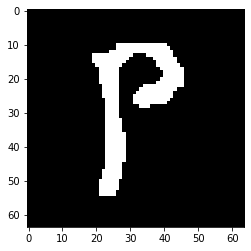

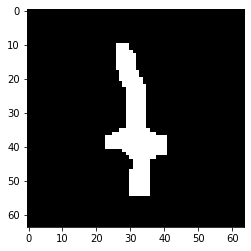

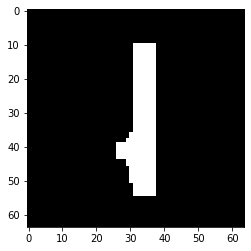

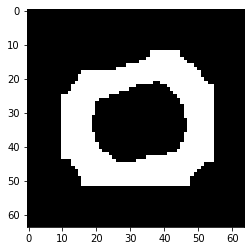

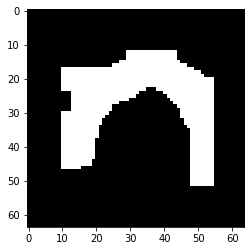

i with p-value 0.9999855756759644
p with p-value 1.0
t with p-value 0.9999988079071045
i with p-value 0.9958767890930176
o with p-value 0.9999964237213135
n with p-value 1.0
iption


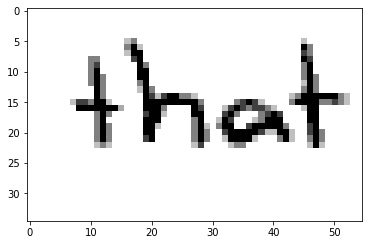

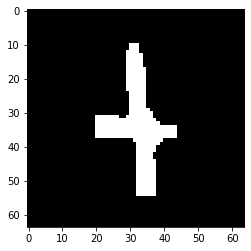

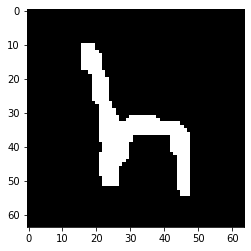

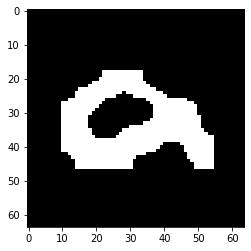

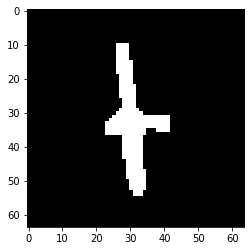

t with p-value 1.0
h with p-value 0.9999998807907104
a with p-value 1.0
t with p-value 0.9999315738677979
that


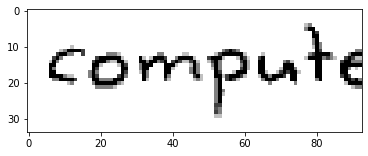

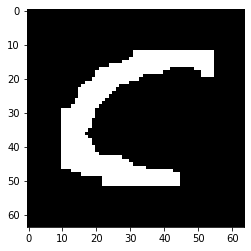

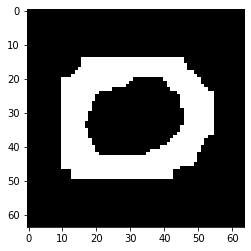

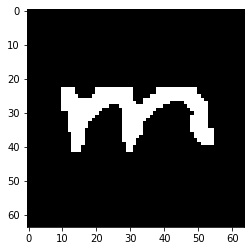

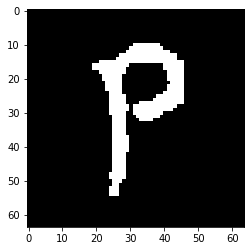

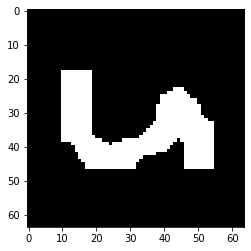

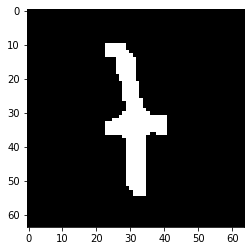

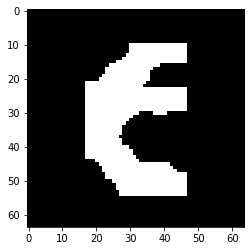

c with p-value 0.9999961853027344
o with p-value 0.9999958276748657
m with p-value 1.0
p with p-value 1.0
u with p-value 1.0
t with p-value 0.9999610185623169
E with p-value 1.0
computE


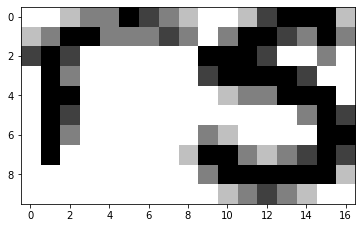

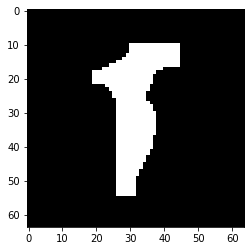

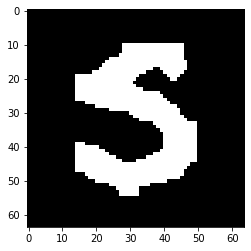

r with p-value 0.9999973773956299
s with p-value 1.0
rs


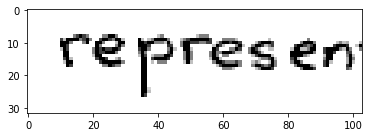

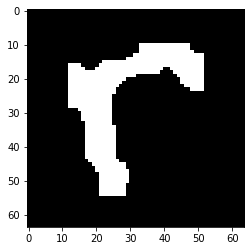

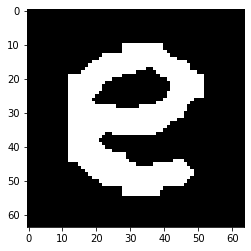

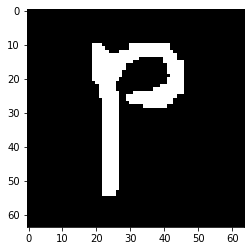

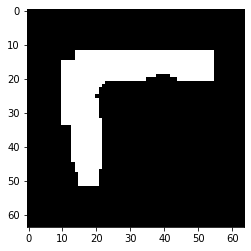

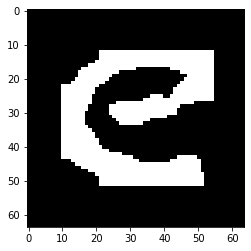

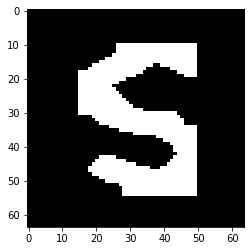

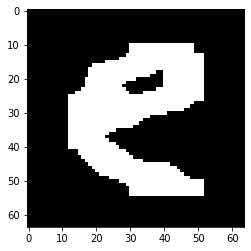

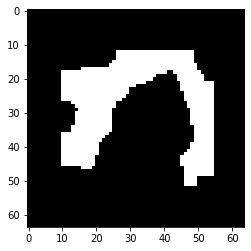

r with p-value 1.0
e with p-value 1.0
p with p-value 1.0
r with p-value 1.0
e with p-value 1.0
s with p-value 1.0
e with p-value 1.0
n with p-value 0.9999991655349731
represen


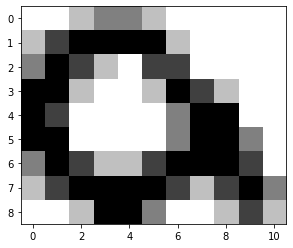

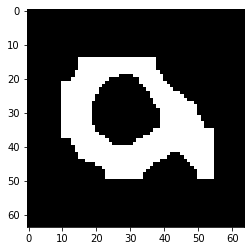

a with p-value 1.0
a


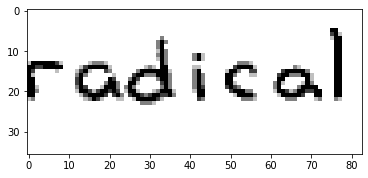

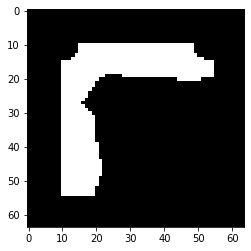

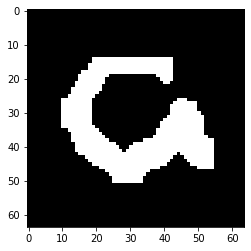

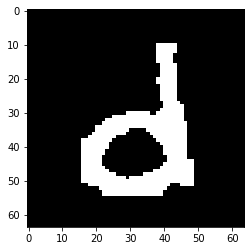

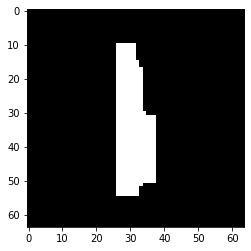

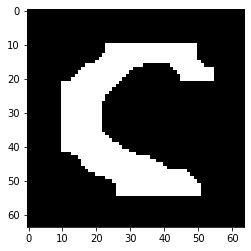

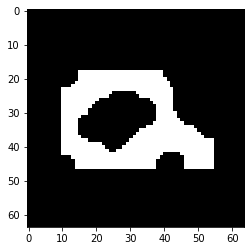

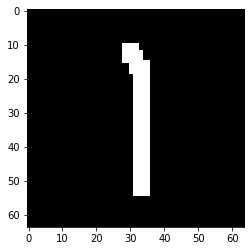

r with p-value 1.0
a with p-value 1.0
d with p-value 1.0
i with p-value 0.9998818635940552
c with p-value 0.9999998807907104
a with p-value 1.0
l with p-value 0.995693027973175
radical


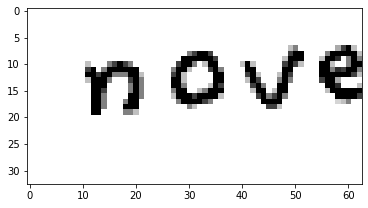

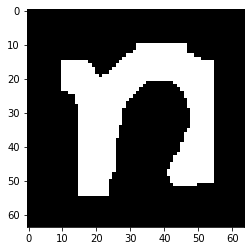

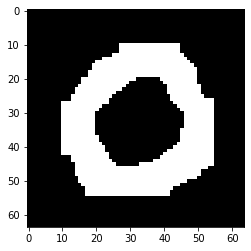

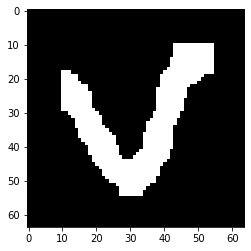

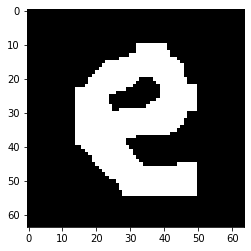

n with p-value 0.999998927116394
o with p-value 1.0
v with p-value 1.0
e with p-value 0.9999998807907104
nove


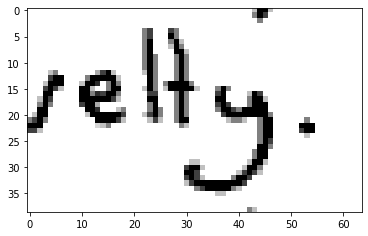

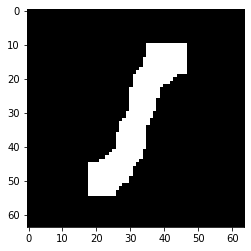

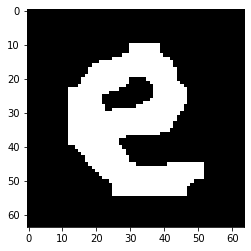

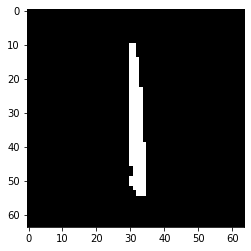

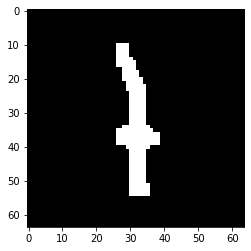

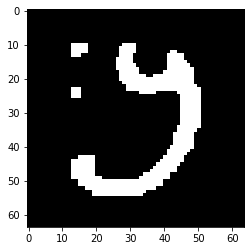

r with p-value 0.9996674060821533
e with p-value 1.0
l with p-value 0.9924551248550415
t with p-value 0.9999315738677979
y with p-value 1.0
relty


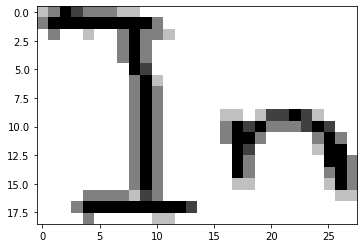

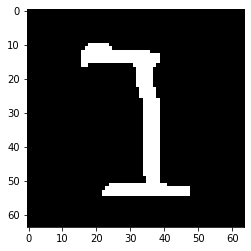

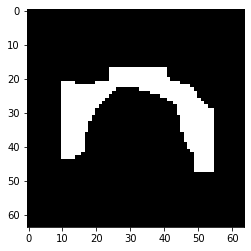

z with p-value 0.9635211825370789
n with p-value 1.0
zn


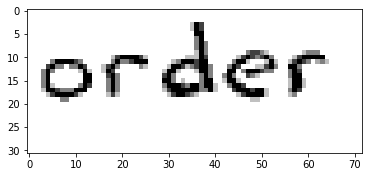

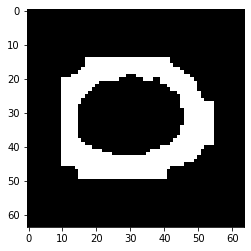

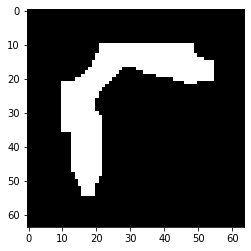

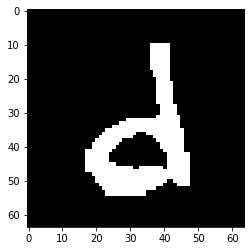

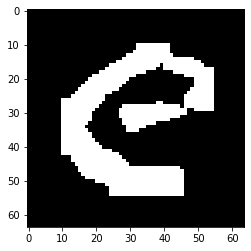

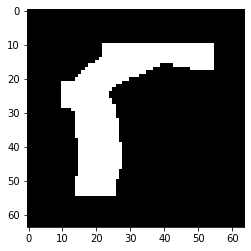

e with p-value 0.9999783039093018
r with p-value 1.0
d with p-value 1.0
e with p-value 1.0
r with p-value 1.0
erder


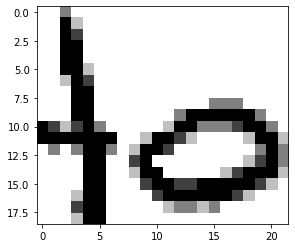

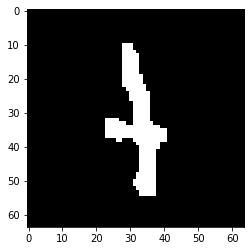

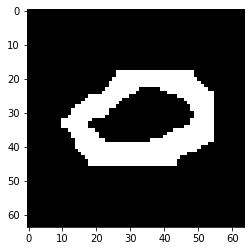

t with p-value 0.9999961853027344
s with p-value 0.9999909400939941
ts


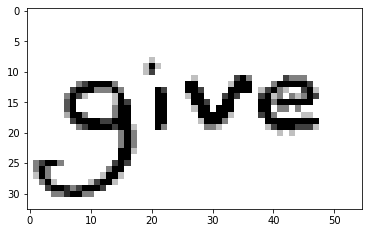

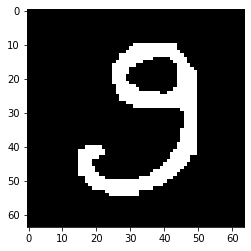

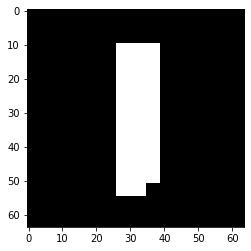

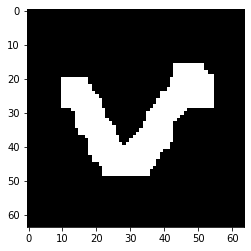

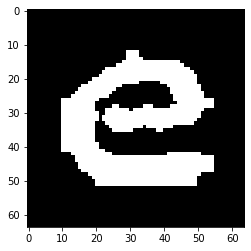

g with p-value 0.9999998807907104
l with p-value 0.9996564388275146
v with p-value 0.9999998807907104
e with p-value 1.0
glve


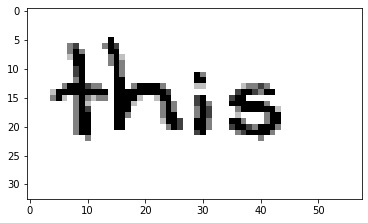

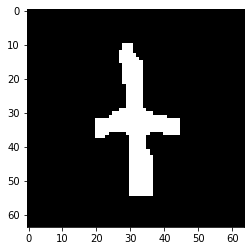

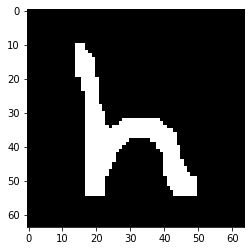

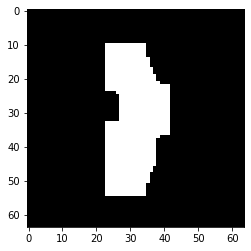

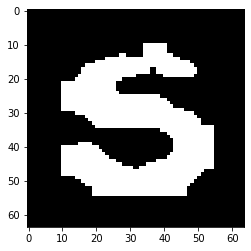

t with p-value 1.0
h with p-value 1.0
j with p-value 0.9931322932243347
s with p-value 1.0
thjs


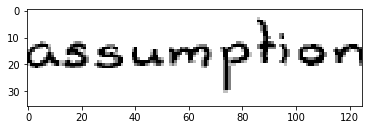

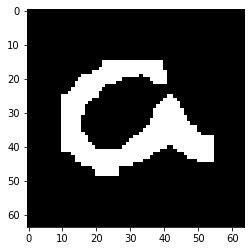

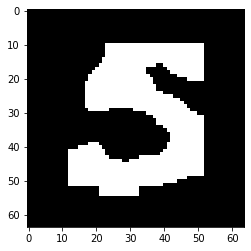

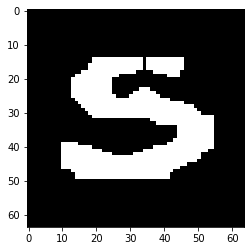

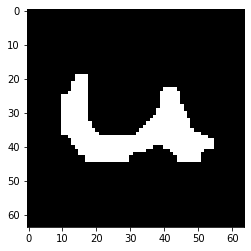

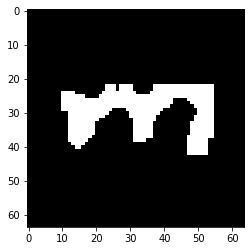

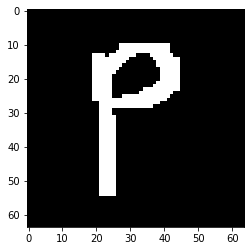

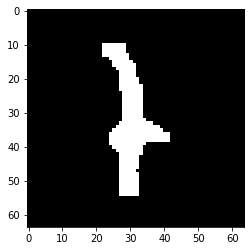

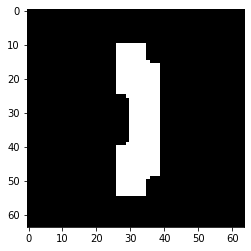

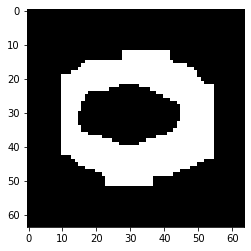

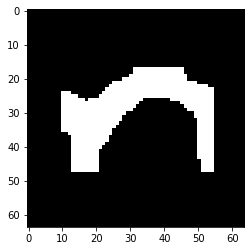

a with p-value 1.0
s with p-value 1.0
s with p-value 1.0
u with p-value 1.0
m with p-value 1.0
p with p-value 1.0
j with p-value 0.999702513217926
i with p-value 0.999697208404541
a with p-value 0.9999997615814209
n with p-value 0.9999972581863403
assumpjian


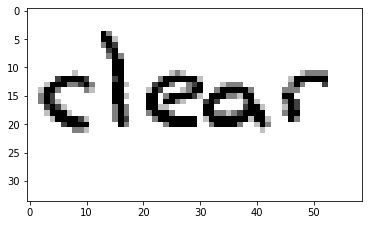

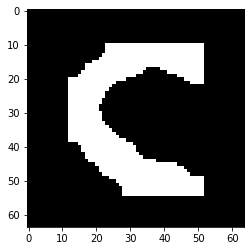

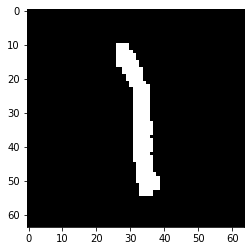

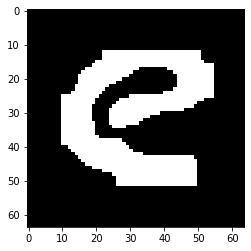

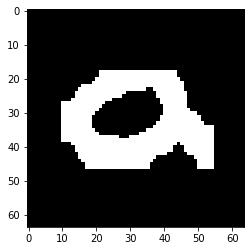

c with p-value 0.9999980926513672
l with p-value 0.9990248680114746
e with p-value 1.0
a with p-value 1.0
clea


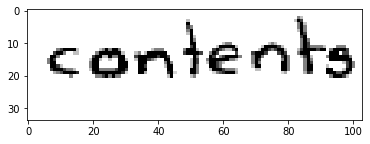

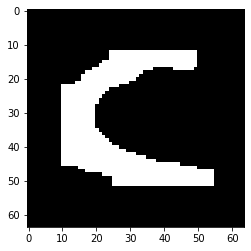

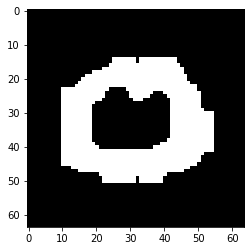

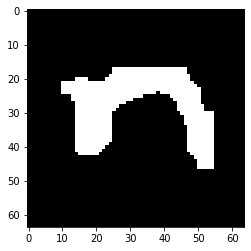

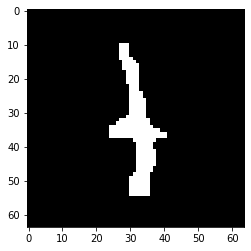

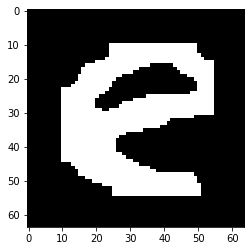

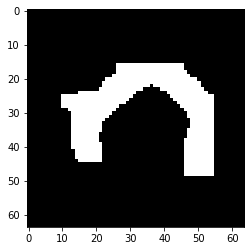

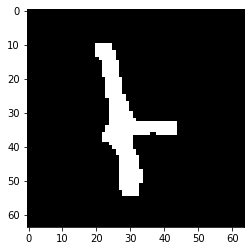

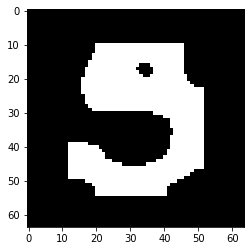

c with p-value 0.9999946355819702
e with p-value 0.9999775886535645
n with p-value 0.9999998807907104
t with p-value 0.9999983310699463
e with p-value 1.0
n with p-value 0.9999985694885254
t with p-value 0.9991297125816345
g with p-value 0.9999998807907104
cententg


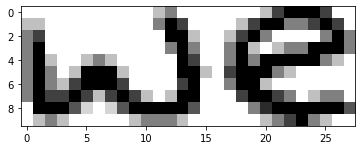

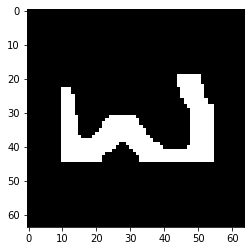

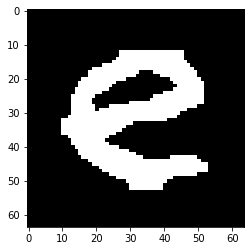

w with p-value 1.0
e with p-value 1.0
we


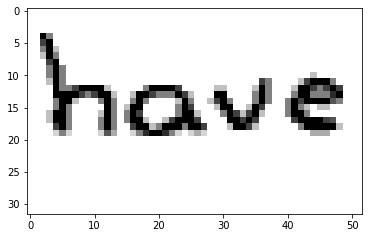

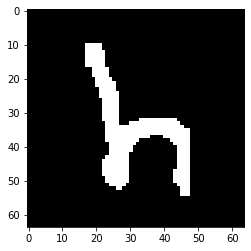

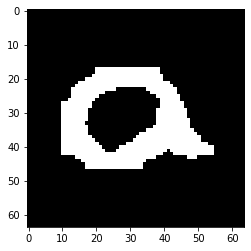

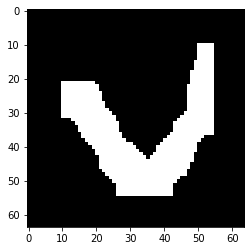

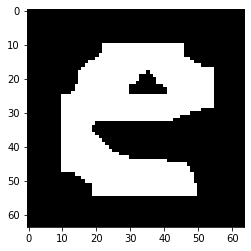

h with p-value 1.0
a with p-value 1.0
u with p-value 1.0
e with p-value 1.0
haue


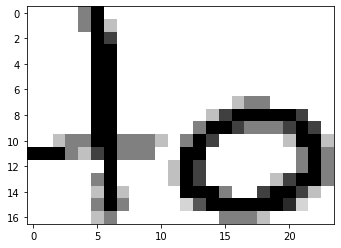

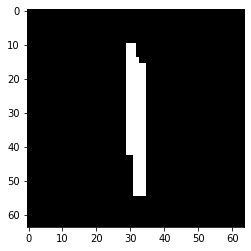

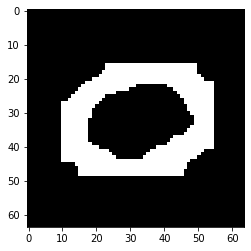

l with p-value 0.9998729228973389
e with p-value 0.9999904632568359
le


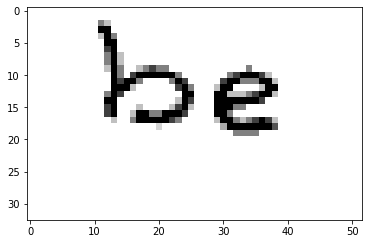

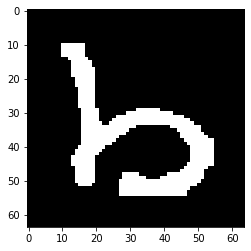

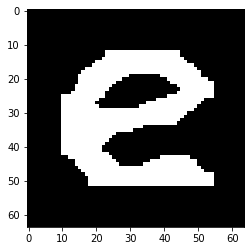

b with p-value 1.0
e with p-value 1.0
be


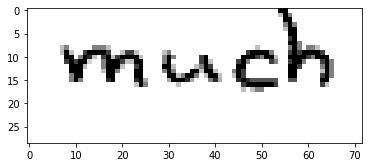

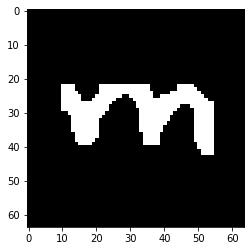

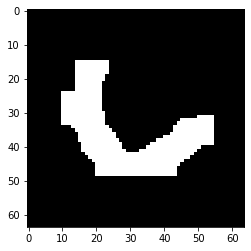

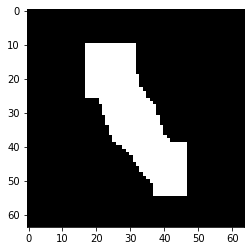

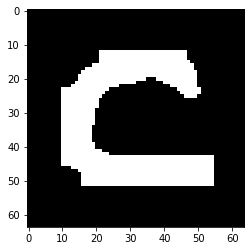

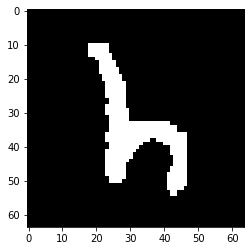

m with p-value 1.0
w with p-value 0.9995371103286743
r with p-value 0.9975520968437195
c with p-value 1.0
h with p-value 0.9999997615814209
mwrch


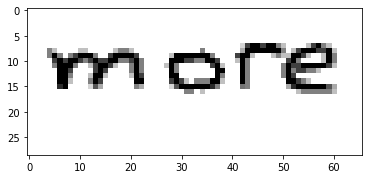

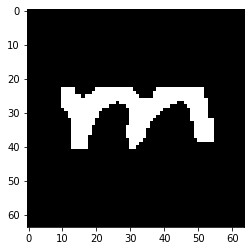

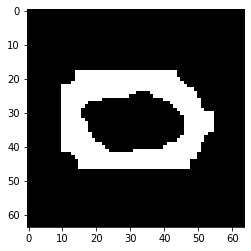

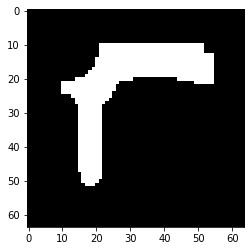

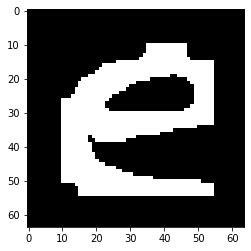

m with p-value 1.0
o with p-value 0.9999699592590332
r with p-value 1.0
e with p-value 1.0
more


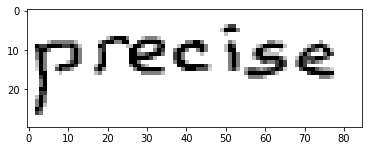

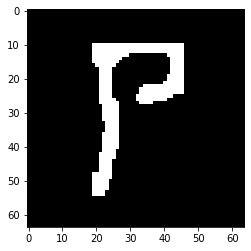

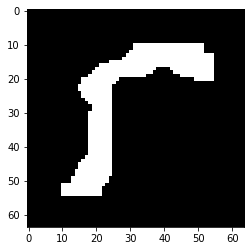

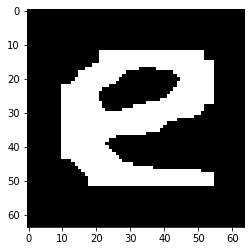

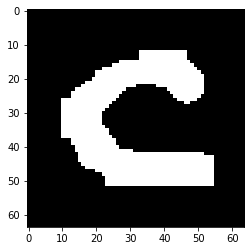

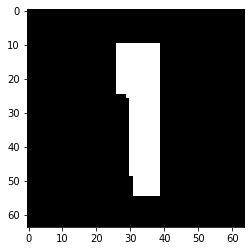

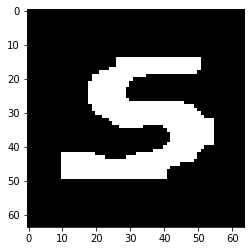

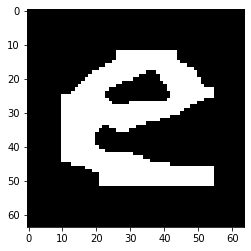

p with p-value 1.0
r with p-value 1.0
e with p-value 1.0
c with p-value 0.9999998807907104
l with p-value 0.9999129772186279
s with p-value 1.0
e with p-value 1.0
preclse


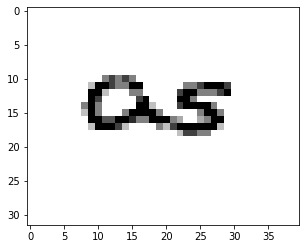

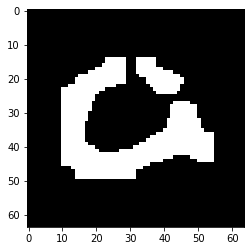

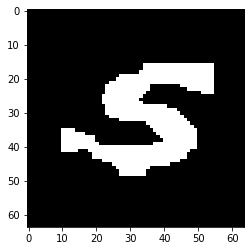

a with p-value 1.0
E with p-value 0.9999992847442627
aE


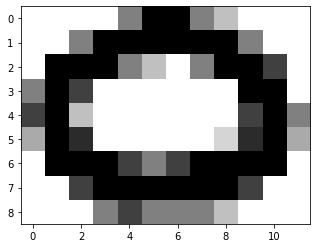

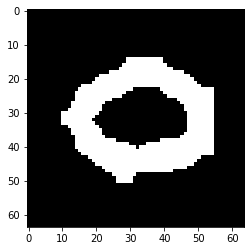

e with p-value 0.9999971389770508
e


In [49]:
# This function takes a letter of any size and fits it into a 64x64 input
# Does not simply resize the letter since its porportions must stay the same
def fit_to_size(img,size):
  img = cv2.cvtColor(img.copy(),cv2.COLOR_RGB2GRAY)
  if img.shape == (size,size):
    return img.copy()

  # add some padding
  padding = 10

  if img.shape[0] > img.shape[1]:
    rows = size - 2*padding
    cols = int(rows/img.shape[0]*img.shape[1])
    c_row = padding
    c_col = (size-cols)//2
  else:
    cols = size - 2*padding
    rows = int(cols/img.shape[1]*img.shape[0])
    c_row = (size-rows)//2
    c_col = padding

  resized = cv2.resize(img, (cols,rows))
  new_img = np.ones((size,size))
  new_img[c_row:c_row+rows,c_col:c_col+cols] = resized/255
  ret,new_img = cv2.threshold(new_img,0.4,1,cv2.THRESH_BINARY_INV)

  return new_img

# Determine the order in which the words were written in the image
# This function determines the number of lines that were written, then
# assignes each word to a line and sorts the (indexes of the) words on each line
def sort_words(coords, thresh = 20):

  # Determine how many lines there are and their locations
  s = sorted(coords,key = lambda c : c[0])
  y_locs = []
  for i in range(len(s)):
    loc = (s[i][3]+s[i][1])/2

    found_same = False
    for l in y_locs:
      if abs(loc-l) <= thresh:
        found_same = True
        break

    if not found_same:
      y_locs.append(loc)
  y_locs.sort() 
  num_rows = len(y_locs)
  lines = [[] for _ in range(num_rows)]

  # assign each word to a line
  for i, coord in enumerate(coords):
    loc = (coord[3]+coord[1])/2

    cloest_idx = None
    closest_dist = 100000000
    for j,l in enumerate(y_locs):
      dist = abs(loc-l)
      if dist < closest_dist:
        closest_dist = dist
        cloest_idx = j

    lines[cloest_idx].append(i)

  # sort the words on each line
  for line in lines:
    line.sort(key = lambda idx : coords[idx][0]) # sort by x

  return lines
  
  """
  for i in range(len(coords)):
    coords[i].append(i)
    coords[i][1] -= coords[i][1] % 10
  
  out = sorted(coords, key = lambda x: (x[1], x[0]))

  order = [x[4] for x in out]
  sorted_words = [word_list[i] for i in order]

  return sorted_words  
  """

# uses sorted indexes to figure out the order of the words
lines = sort_words(word_coords) # get lines with idxs
sorted_words = []
for line in lines:
  for idx in line:
    sorted_words.append(words[idx])

# Determines what was written in the image
def get_parsed_text(sorted_words, model, output_mapper):
  full_output = ''
  for i,word in enumerate(sorted_words):
    plt.imshow(word,cmap='gray')
    plt.show()

    # Determine the letters in each word
    im,rectangles = detect_with_thresh(word) 

    # Combine the letters for each word into one tensor
    rectangles = sorted(rectangles, key = lambda x: (x[0]))
    t = torch.ones([len(rectangles),1,64,64])
    for i,rect in enumerate(rectangles):
      letter = fit_to_size(word[rect[1]:rect[3],rect[0]:rect[2]],64)
      letter = cv2.dilate(letter,kernel=np.ones((2,2)))
      t[i,0] = torch.tensor(letter)
      plt.figure()
      plt.imshow(letter,cmap='gray')
      plt.show()

    # Determine the prediction of the model
    prediction = torch.sigmoid(model(t.cuda()))
    top_p, top_class = prediction.topk(1, dim=1)
    out_str = ''
    for i,c in enumerate(top_class):
      val = output_mapper[c.item()]
      print(val,'with p-value',top_p[i].item())
      out_str += val
    print(out_str)
    full_output += out_str + ' '
  return full_output

full_output = get_parsed_text(sorted_words, char_model, map_targets_to_chars)

In [0]:
# SECTION 5
# Use a spell checker on the output of the model to make it better

In [0]:
!pip install pyspellchecker

In [292]:
from spellchecker import SpellChecker

spell = SpellChecker(distance=2)

# Determine permutations of letters that the model commonly makes mistakes on
def permute(word, curr, spell, perms):
  out = []
  permutations = {'i': 'l', 'l': 'i', 'o': 'e', 'e': 'o', 'g': 'q', 'q': 'g', 'A': 'o'}
  
  for i, char in enumerate(word):
    if char in permutations:
      out.extend(permute(word[i + 1:], curr + [permutations[char]], spell, perms + 1))

    curr.append(char)

  potentialWord = ''.join(curr)
  if len(spell.known([potentialWord])) == 1:
    out.append((potentialWord, perms))
  
  if len(spell.known([spell.correction(potentialWord)])) > 0:
    out.append((spell.correction(potentialWord), perms))
  
  return out
  
separated_words = full_output.split()

# Spellcheck each word
for i, word in enumerate(separated_words):
  tmp = word.find('vv')
  
  if tmp != -1:
    word = word[:tmp] + 'w' + word[tmp + 1:]

  possible = permute(word, [], spell, 0)
  print('word == ', word)
  print('possible words == ', possible)
  possible = sorted(possible, key = lambda x: x[1])
  if len(possible) == 0:
    separated_words[i] = word
  else:
    separated_words[i] = spell.correction(possible[0][0])
  

spellchecked_words = ' '.join(separated_words)
print(full_output)
print(spellchecked_words)

word ==  lue
possible words ==  [('duo', 2), ('due', 1), ('luo', 1), ('luo', 1), ('blue', 0)]
word ==  staRt
possible words ==  [('staRt', 0), ('staRt', 0)]
word ==  wvlth
possible words ==  [('with', 1), ('with', 0)]
word ==  Gfood
possible words ==  [('feed', 2), ('good', 1), ('good', 1), ('good', 0)]
word ==  Because
possible words ==  [('because', 2), ('because', 1), ('because', 1), ('Because', 0), ('Because', 0)]
word ==  all
possible words ==  [('air', 2), ('ail', 1), ('ail', 1), ('ali', 1), ('ali', 1), ('all', 0), ('all', 0)]
word ==  wsinesses
possible words ==  [('witnesses', 1), ('businesses', 0)]
word ==  should
possible words ==  [('should', 2), ('should', 1), ('should', 1), ('should', 0), ('should', 0)]
word ==  be
possible words ==  [('bo', 1), ('bo', 1), ('be', 0), ('be', 0)]
word ==  daing
possible words ==  [('dawn', 2), ('dang', 1), ('daine', 1), ('doing', 0)]
word ==  somu
possible words ==  [('semi', 1), ('some', 0)]
word ==  thlnl
possible words ==  [('think', 2), 

In [0]:
# SECTION 6
# Math Equation Recognition using ML

In [0]:
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

# LOAD DATA

class dilate(object):
  def __call__(self, sample):
    dilated = cv2.dilate(np.float32(sample),kernel=np.ones((2,2)))
    ret,dilated = cv2.threshold(dilated,0.4,1,cv2.THRESH_BINARY)
    return dilated

transform = transforms.Compose([#transforms.Resize((128,128)),                             
                                transforms.Grayscale(),
                                dilate(),
                                transforms.ToTensor()
                               ])

dataset = datasets.ImageFolder(
      root=project_dir+'Data/math_symbols/',
      transform= transform,
  )

batch_size = 100
validation_split = .2
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

loader= torch.utils.data.DataLoader(
  dataset,
  batch_size=batch_size
)

# https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

math_train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
math_validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [0]:
# Targets
from itertools import chain
math_valid_targets = set(chain([42,43,45,47,60,61,62], range(48,58), [107,109])) # math symbols + digits + letters j,k (vars)

targets = [chr(c) for c in math_valid_targets]
combo = list(zip(math_valid_targets, targets))
combo.sort(key = lambda x: str(x[0])) # sort alphabetically
map_targets_to_math = list(dict(combo).values()) # targets start from 0, so just need a list

In [0]:
# Init the model and set the optimizers
math_model = CNN_recognizer(len(math_valid_targets)).cuda()

math_criterion = nn.CrossEntropyLoss()
math_optimizer = optim.Adam(math_model.parameters(), lr=0.001)

In [28]:
# Load the model
math_model.load_state_dict(torch.load(project_dir+'Models/math_recognizer.tar'))

<All keys matched successfully>

In [0]:
# train
epochs = 20
for e in range(epochs):
    print('epoch', e+1) 
    running_loss = 0
    for batch, (images, labels) in enumerate(math_train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()

        vals = math_model(images)
        loss = math_criterion(vals, labels)
        print('batch:',batch,"     ",'loss:',loss.item())
 
        math_optimizer.zero_grad()
        loss.backward()
        math_optimizer.step()
        
        running_loss += loss.item()
    print(f"Training loss: {running_loss/len(math_train_loader)}")

In [0]:
# Save the model
#torch.save(math_model.state_dict(), project_dir+'Models/math_recognizer.tar')

In [0]:
# validate
accuracy = 0
for images, labels in math_validation_loader:
    images = Variable(images).cuda()
    labels = Variable(labels).cuda()

    vals = math_model(images)

    # get the predictions: argmax etc.
    ps = torch.sigmoid(vals)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    acc = torch.mean(equals.type(torch.FloatTensor))
    print(acc)
    accuracy += acc
        
print("Test Accuracy: {:.3f}".format(accuracy/len(math_validation_loader)))

tensor(0.9600)
tensor(0.9500)
tensor(0.9500)
tensor(0.9400)
tensor(0.9800)
tensor(0.9600)
tensor(0.9800)
tensor(0.9500)
tensor(0.9500)
tensor(0.9500)
tensor(0.9600)
tensor(0.9600)
tensor(0.9900)
tensor(0.9800)
tensor(0.9700)
tensor(0.9600)
tensor(0.9800)
tensor(0.9800)
tensor(0.9600)
tensor(0.9700)
tensor(0.9600)
tensor(0.9800)
tensor(0.9400)
tensor(0.9600)
tensor(0.9900)
tensor(0.9600)
tensor(0.9836)
Test Accuracy: 0.965


In [0]:
# SECTION 7
# Load and parse images to math equations

In [0]:
math1 = load_img("math1","jpg")
math1 = cv2.resize(math1, (0,0), fx=0.1, fy=0.1)
math2 = load_img("math2","jpg")
math2 = cv2.resize(math2, (0,0), fx=0.1, fy=0.1)
math3 = load_img("math3","jpg")
math3 = cv2.resize(math3, (0,0), fx=0.1, fy=0.1)

In [0]:
# Detect the math smybols
def detect_math_with_thresh(input_img): # detects all math chars in entire image
  im = cv2.cvtColor(input_img.copy(),cv2.COLOR_RGB2GRAY)
  ret, thresh = cv2.threshold(im, 100, 255, cv2.THRESH_BINARY_INV)

  # Different versions of open cv
  #
  major = cv2.__version__.split('.')[0]
  if major == '3':
    _, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  else:
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  rectangles = []
  symbols = []
  for i, ctr in enumerate(contours):
      x, y, w, h = cv2.boundingRect(ctr)

      if w <= 8 and h <= 8:
        continue

      if hierarchy[0, i, 3] == -1:
          concat = False
          removed = None
          w1,h1,w2,h2 = x,y,x+w,y+h
          for i,r in enumerate(rectangles):
            wr1,hr1,wr2,hr2 = r

            # combine rects if the they are too close to others w.r.t height
            # this helps detect '=' signs
            if min(abs(h2-hr1),abs(h2-hr2),abs(h1-hr1),abs(h1-hr2)) < 10 and \
               min(abs(w2-wr1),abs(w2-wr2),abs(w1-wr1),abs(w1-wr2)) < 5:
              del rectangles[i]
              concat = True
              removed = r[:]
              break

          if not concat:
            r = [x, y, x + w, y + h]
          else:
            r = [min(x,r[0]), min(y,r[1]),max(x+w,r[2]),max(y+h,r[3])]
          
          rectangles.append(r)          

  for r in rectangles:
    cv2.rectangle(im, (r[0], r[1]), ( r[2], r[3]), (0, 255, 0), 1)
    symbols.append(input_img[r[1]:r[3],r[0]:r[2]])
  
  return im, rectangles, symbols

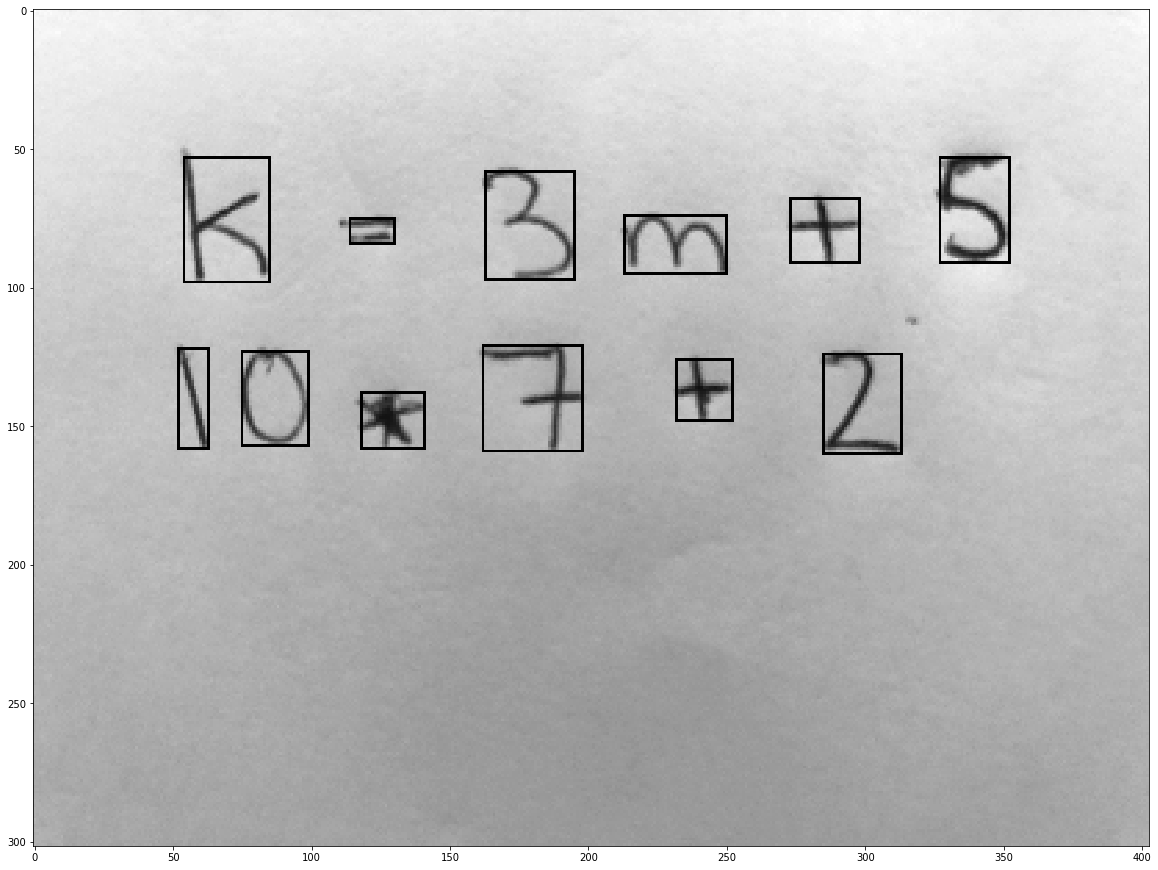

In [31]:
thresh, math_rectangles, symbols = detect_math_with_thresh(math3)
plt.figure(figsize=(20,20))
plt.imshow(thresh,cmap='gray')

In [0]:
# Sort the symbols
math_equations = sort_words(math_rectangles, thresh=40)

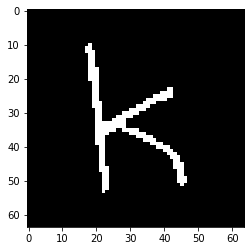

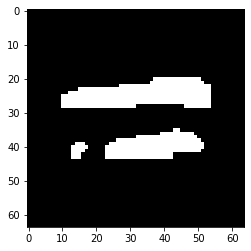

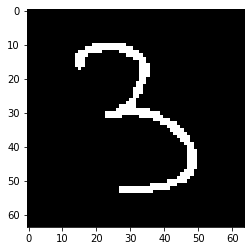

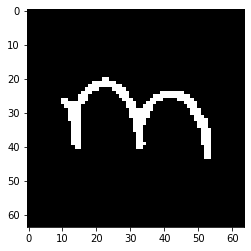

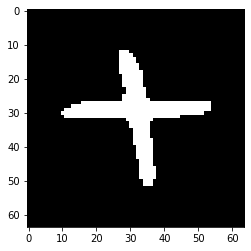

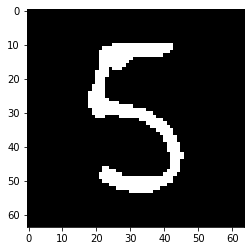

k with p-value 0.9999657869338989
= with p-value 0.9999945163726807
3 with p-value 1.0
m with p-value 1.0
+ with p-value 1.0
5 with p-value 1.0
k=3m+5


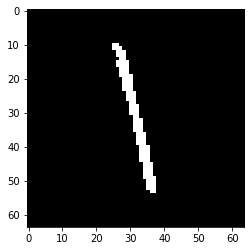

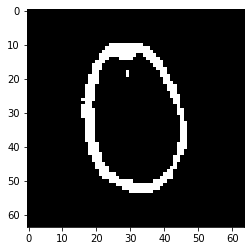

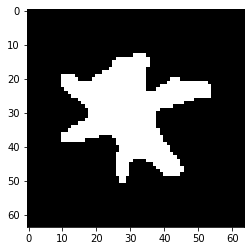

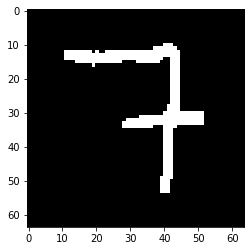

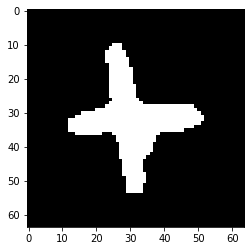

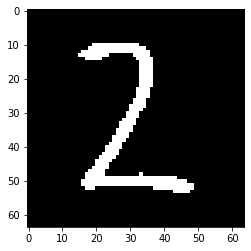

1 with p-value 0.9999998807907104
0 with p-value 0.9999971389770508
* with p-value 1.0
7 with p-value 0.9999938011169434
+ with p-value 0.9999996423721313
2 with p-value 1.0
10*7+2
['k=3m+5', '10*7+2']


In [33]:
# Feed math symbols into the model
from statistics import mean
def get_parsed_math(math_equations, model, output_mapper):
  full_output = []
  for j, equation in enumerate(math_equations):
    full_output.append('')
    t = torch.ones([len(equation),1,64,64])

    coords = []
    for i,idx in enumerate(equation):
      symbol = fit_to_size(symbols[idx],64)
      t[i,0] = torch.tensor(symbol)
      coords.append(math_rectangles[idx])
      plt.figure()
      plt.imshow(symbol,cmap='gray')
      plt.show()
    prediction = torch.sigmoid(model(t.cuda()))
    top_p, top_class = prediction.topk(1, dim=1)

    # average y coorindate of the line to be used to find exponents
    avg_y_coord = mean([(c[3]+c[1])/2 for c in coords])

    for i,c in enumerate(top_class):
      val = output_mapper[c.item()]
      print(val,'with p-value',top_p[i].item())

      # if output is above the average y, it is an exponent
      if coords[i][3] + 3 < avg_y_coord:
        val = '^'+val
      full_output[j] += val
    print(full_output[j])
  
  return full_output
full_output = get_parsed_math(math_equations, math_model, map_targets_to_math)
print(full_output)

In [0]:
# SECTION 8
# Solve the math equations using wolframalpha api

In [35]:
!pip install wolframalpha

In [0]:
import wolframalpha
client = wolframalpha.Client('PEERV2-RR6L768AQX')

In [38]:
for query in full_output:
  res = client.query(query)
  print('Q:', query)
  count = 0
  for pod in res.pods:
    if pod.text is not None:
      if count == 0:
        print('A: {}'.format(pod.text))
        count += 1
      else:
        print('   {}'.format(pod.text))
  print()

Q: k=3m+5
A: k = 3 m + 5
   line
   k - 3 m - 5 = 0
   m = -5/3
   d/dm(3 m + 5) = 3

Q: 10*7+2
A: 10×7 + 2
   72
   seventy-two
   10 7 + 2 = 72 is 2.857% larger than 10 7 = 70.

